# Setup

Run following command in your terminal:

    $ pip install -r requirements.txt

# Retrieve Zip Code List

In [1]:
import os
import json
import ntpath
import wget

In [2]:
"""
Reference: https://catalog.data.gov/dataset/bay-area-zip-codes
"""
def get_bay_area_zipcode():
    
    url = "https://data.sfgov.org/api/views/f9wk-m4qb/rows.json?accessType=DOWNLOAD"
    filename = "rows.json"

    # Remove previous downloaded csv file if exists
    try:
        os.remove(ntpath.basename(filename))
    except OSError:
        pass
    
    filename = wget.download(url)
    with open(filename) as f:
        raw_data = json.load(f)
        zipcode_list = [row[10] for row in raw_data["data"]]
    return zipcode_list

In [3]:
zipcode_list = get_bay_area_zipcode()
print(zipcode_list[:10])

['94558', '94533', '95620', '95476', '94559', '94954', '94571', '94535', '94503', '94949']


# Retrieve Income Data

In [4]:
import re
import requests
from bs4 import BeautifulSoup

In [5]:
"""
Source: https://factfinder.census.gov/faces/nav/jsf/pages/community_facts.xhtml
Example: https://factfinder.census.gov/rest/communityFactsNav/nav?spotlightId=INCOME&searchTerm=94041
"""
def get_avg_income_by_zipcode(zipcode):
    url = "https://factfinder.census.gov/rest/communityFactsNav/nav?spotlightId=INCOME&searchTerm=" + str(zipcode)
    req = requests.get(url=url)
    html = req.json()["CFMetaData"]["measureAndLinksContent"]
    dom = BeautifulSoup(html, "lxml")
    try:
        income = re.sub('[^0-9]','', dom.findAll("div", {"class": "value"})[0].text)
    except Exception:
        print("No value found for zipcode %s" % zipcode)
        return None
    print(zipcode, income)
    return income

In [6]:
# Test
zipcode = 94558
avg_income = get_avg_income_by_zipcode(zipcode)

94558 77299


In [7]:
def get_zipcode_income_map(zipcode_list):
    zipcode2income = {}
    for zipcode in zipcode_list:
        income = get_avg_income_by_zipcode(zipcode)
        if income:
            zipcode2income[zipcode] = int(income)
    return zipcode2income

In [8]:
zipcode2income = get_zipcode_income_map(zipcode_list)

94558 77299
94533 57316
95620 72583
95476 68894
94559 65891
94954 83713
94571 54852
94535 54692
94503 83627
94949 78568
94945 90685
No value found for zipcode 94512
94591 73897
94510 87569
94592 110648
94589 57316
94947 88119
94590 41530
94946 108750
94561 81910
94525 78750
94569 136875
94585 70491
94103 46140
94565 60020
94903 92552
94520 51096
94572 70227
94553 84638
94547 102993
94963 91806
94938 103854
94502 115765
94509 55022
94960 112045
94513 93951
94109 71043
94521 88339
94930 99338
94973 90824
94933 76393
94598 125089
94564 73861
94801 43393
94519 74351
94806 52698
94901 82231
94531 90126
94803 78759
94601 41918
94523 94042
94518 78301
94904 111845
94115 97090
94549 147368
94517 128398
94805 72009
94804 51276
94939 99844
94964 107167
94530 91052
94925 125915
94596 82869
94708 147837
94105 195165
94941 131703
94563 174526
No value found for zipcode 94720
94707 140711
94514 54348
94970 109412
94706 86043
94710 63080
94104 51500
94595 62374
94709 63701
94703 68842
94704 26173
945

# Retrieve Shape Data

In [9]:
import os
import zipfile
import shutil
import shapefile

In [10]:
"""
Source: https://www.census.gov/geo/maps-data/data/cbf/cbf_zcta.html
"""
def download_zipcode_shapefile():
    
    url = "http://www2.census.gov/geo/tiger/GENZ2016/shp/cb_2016_us_zcta510_500k.zip"
    output = "./data/"
    target = "./data/cb_2016_us_zcta510_500k.shp"
    
    # Remove previous extracted folder if exists
    try:
        shutil.rmtree(output)
    except OSError:
        pass
    
    # Remove previous downloaded zip file if exists
    try:
        os.remove(ntpath.basename(url))
    except OSError:
        pass
    
    # Download and extract
    zip_data = wget.download(url)
    with zipfile.ZipFile(zip_data) as zip_ref:
        zip_ref.extractall(output)
        
    return target

In [11]:
raw_data = download_zipcode_shapefile()
shape_records = shapefile.Reader(raw_data).shapeRecords()

In [12]:
def filter_shape_record(shape_records, zipcode_list):
    filtered = []
    for sr in shape_records:
        if sr.record[0] in zipcode_list:
            filtered.append(sr)
    return filtered

In [13]:
filtered_shape_records = filter_shape_record(shape_records, zipcode_list)
print(len(filtered_shape_records), len(zipcode_list))

186 187


# Plot

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm as cmx

In [15]:
def get_normalized_df(dic):
    df = pd.DataFrame.from_dict(dic, orient = "index")
    df.columns = ["income"]
    return (df - df.min()) / (df.max() - df.min())

In [16]:
normalized_df = get_normalized_df(zipcode2income)
print(normalized_df.get_value("94558", "income"))

0.235203731903


In [17]:
"""
Reference: https://gis.stackexchange.com/questions/131716/plot-shapefile-with-matplotlib
"""
def plot_shapes(shape_records, record2value):
    plt.figure()
    for sr in shape_records:
        index = sr.record[0]
        try:
            val = record2value.get_value(index, "income")
        except KeyError:
            continue
        x = [i[0] for i in sr.shape.points[:]]
        y = [i[1] for i in sr.shape.points[:]]
        plt.fill(x, y, get_heapmap_color_hex(val))
    plt.show()

In [18]:
"""
Jet colormap: https://www.mathworks.com/help/matlab/ref/jet.html
"""
def get_heapmap_color_hex(val):
    r, g, b = plt.cm.jet(val)[:3]
    return "#%02x%02x%02x" % (int(r * 255), int(g * 255), int(b * 255))

In [19]:
print(get_heapmap_color_hex(0.5))
print(get_heapmap_color_hex(1.0))

#7cff79
#7f0000


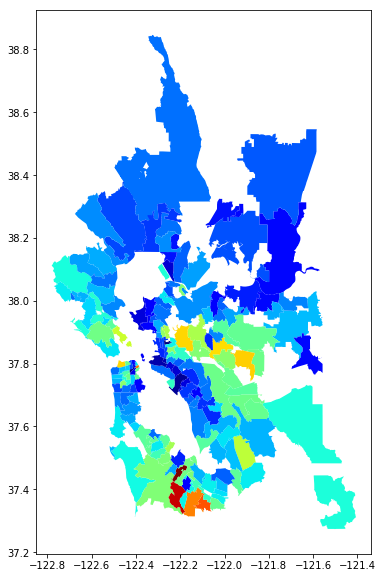

In [20]:
plt.rcParams["figure.figsize"] = [6, 10] # Size: [width, height]
plot_shapes(filtered_shape_records, normalized_df)